- https://wikidocs.net/44249

## 모듈

In [1]:
import re
import numpy as np
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
from tqdm import tqdm
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 데이터 로딩

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x1bf941ce700>)

In [3]:
train=pd.read_table('ratings_train.txt')
test=pd.read_table('ratings_test.txt')

In [4]:
train.head(5)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
test.head(5)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [6]:
print(f'train 갯수 : {train.shape}, test 갯수 : {test.shape}')

train 갯수 : (150000, 3), test 갯수 : (50000, 3)


In [7]:
train['document'].unique(), train['label'].unique()

(array(['아 더빙.. 진짜 짜증나네요 목소리', '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나',
        '너무재밓었다그래서보는것을추천한다', ..., '이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?',
        '청춘 영화의 최고봉.방황과 우울했던 날들의 자화상', '한국 영화 최초로 수간하는 내용이 담긴 영화'],
       dtype=object),
 array([0, 1], dtype=int64))

In [8]:
# document 열과 label 열의 중복을 제외한 값의 개수
train['document'].nunique(), train['label'].nunique()

(146182, 2)

In [9]:
# document 열의 중복 제거
train.drop_duplicates(subset=['document'], inplace=True)

In [10]:
len(train)

146183

In [30]:
train['label'].value_counts()

0    73342
1    72841
Name: label, dtype: int64

<AxesSubplot:>

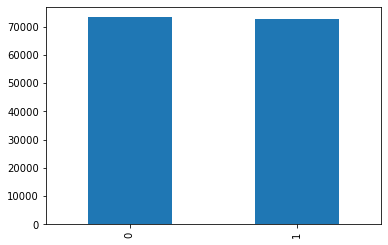

In [29]:
train['label'].value_counts().plot(kind = 'bar')

(73342, 72841)

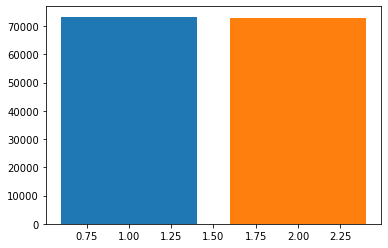

In [28]:
train['label'].value_counts()
# tlabel[0], tlabel[1]
# plt.bar(1, tlabel[0])
# plt.bar(2, tlabel[1])
# plt.show()